<a href="https://colab.research.google.com/github/namirinz/YSC21-AI_KME/blob/master/Image_Captioning/KME_Image_captioning_bahdanau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nami --upgrade
!pip install tqdm
!rm -rf .keras

In [2]:
!nvidia-smi

Mon Nov  9 15:42:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import nami
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

8192/667 [================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [4]:
(X_train, y_train), (X_test, y_test) = nami.datasets.kme.load_data()

102662144/102660224 [==============================] - 1s 0us/step


# Import Dataset

In [5]:
from nami.datasets.kme import load_data
(image_train, caption_train), (image_test, caption_test) = load_data()
print(image_train.shape, caption_train.shape)
print(image_test.shape, caption_test.shape)

(545, 224, 224, 3) (545,)
(137, 224, 224, 3) (137,)


## Preprocessing Dataset

In [6]:
from nami.AI.kme_tokenize import Tokenizer
tokenizer = Tokenizer()

In [7]:
tokenizer.fit_on_texts(caption_train)

In [8]:
text2seq_train = tokenizer.text_to_sequences(caption_train)
seq2text_train = tokenizer.sequences_to_text(text2seq_train)

In [9]:
text2seq_test = tokenizer.text_to_sequences(caption_test)
seq2text_test = tokenizer.sequences_to_text(text2seq_test)

In [10]:
text2seq_train.shape

(545, 35)

## Hyperparameter

In [11]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000
units = 512
vocab_size = len(tokenizer.word2index)

num_steps_train = len(image_train) // BATCH_SIZE
num_steps_test = len(image_test) // BATCH_SIZE

max_length_train = text2seq_train.shape[1]
max_length_test = text2seq_test.shape[1]

encoding_size = 256 # Determines dimension of the encodings of images

## tf.data.Dataset


In [12]:
def rescale_fn(image, label):
  return tf.cast(image, tf.float32) / 255.0, label

In [13]:
import random
def prob_fn():
  return random.random()

In [14]:
import random
def augment_fn(image, label):
  image, label = rescale_fn(image, label)
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  
  # Rotate clockwise
  if prob_fn() > 0.5:
    image = tf.image.rot90(image, k = random.randint(0, 4))
  # Add some noise
  if prob_fn() > 0.5:
    gnoise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32)
    image = tf.add(image, gnoise)
  
  return image, label

In [15]:
with tf.device('/cpu:0'):
  dataset = tf.data.Dataset.from_tensor_slices((image_train, text2seq_train)).map(
      augment_fn, num_parallel_calls = tf.data.experimental.AUTOTUNE
  ).shuffle(
    len(image_train)
  ).batch(
      BATCH_SIZE
  ).cache(      
  ).prefetch(
      tf.data.experimental.AUTOTUNE
)

In [16]:
with tf.device('/cpu:0'):
  dataset_val = tf.data.Dataset.from_tensor_slices((image_test, text2seq_test)).map(
      rescale_fn, num_parallel_calls = tf.data.experimental.AUTOTUNE
  ).shuffle(
    len(image_test)
  ).batch(
      BATCH_SIZE
  ).cache(      
  ).prefetch(
      tf.data.experimental.AUTOTUNE
)

# Model Architecture

## EfficientNetB7 

In [17]:
from tensorflow.keras.applications import efficientnet

EffNet = efficientnet.EfficientNetB7(include_top = False, weights=None, input_shape=(224, 224, 3))
# Output shape = [batch_size, 7, 7, 2560]

## CNN Encoder (Encoder output of feature extraction)

In [18]:
from tensorflow.keras.models import Sequential
encoder = Sequential([
    EffNet,
    tf.keras.layers.Dense(encoding_size,activation='relu',name="encoding_layer"),
    tf.keras.layers.Reshape(target_shape=(7*7, encoding_size))
], name= "CNN_feature_extraction")

In [19]:
encoder.summary()

Model: "CNN_feature_extraction"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
encoding_layer (Dense)       (None, 7, 7, 256)         655616    
_________________________________________________________________
reshape (Reshape)            (None, 49, 256)           0         
Total params: 64,753,303
Trainable params: 64,442,576
Non-trainable params: 310,727
_________________________________________________________________


## Bahdanau Attention (Class)

In [20]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 25, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 25, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 25, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 25, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

## RNN Decoder (Class)


In [21]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, encoding_size, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, encoding_size)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def __call__(self,features, x, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, encoding_size)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, encoding_size + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x, initial_state=[hidden])

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [22]:
decoder = RNN_Decoder(encoding_size = encoding_size, units = units, vocab_size = vocab_size)

# Sub Class Model

In [23]:
"""
class ImageBahda(tf.keras.Model):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.hidden_state = None
    self.decoder_input = None
  
  def compile(self, word_loss_fn, eos_loss_fn, encoder_opt, decoder_opt, metrics):
    super().__init__()
    self.word_loss_fn = word_loss_fn
    self.eos_loss_fn = eos_loss_fn
    self.encoder_opt = encoder_opt
    self.decoder_opt = decoder_opt
    self.metrics = metrics

  def train_step(self, input):
    image, caption = input
    batch_size = tf.shape(input)[0]
    
    self.hidden_state = self.decoder.reset_state(batch_size = batch_size)
    self.decoder_input = tf.expand_dims([tokenizer.word2index['<start>']] * batch_size, 1)
    
    with tf.GradientTape() as dec_tape, tf.GradientTape() as enc_tape:
      img_feature = encoder(img_tensor)
        
      for i in range(1, max_length_train):
        # passing the features through the decoder
        predictions, hidden_state, _ = decoder(img_feature, dec_input, hidden_state)

        word_loss += word_loss_function(target[:,i], predictions)
        eos_loss += eos_loss_function(target[:, i], predictions)
        loss += word_loss + eos_loss

        # using teacher forcing
        dec_input = tf.expand_dims(target[:, i], 1)
      
      # Metrics
      #train_acc.update_state(target[:, i], predictions)
"""

"\nclass ImageBahda(tf.keras.Model):\n  def __init__(self, encoder, decoder):\n    super().__init__()\n    self.encoder = encoder\n    self.decoder = decoder\n    self.hidden_state = None\n    self.decoder_input = None\n  \n  def compile(self, word_loss_fn, eos_loss_fn, encoder_opt, decoder_opt, metrics):\n    super().__init__()\n    self.word_loss_fn = word_loss_fn\n    self.eos_loss_fn = eos_loss_fn\n    self.encoder_opt = encoder_opt\n    self.decoder_opt = decoder_opt\n    self.metrics = metrics\n\n  def train_step(self, input):\n    image, caption = input\n    batch_size = tf.shape(input)[0]\n    \n    self.hidden_state = self.decoder.reset_state(batch_size = batch_size)\n    self.decoder_input = tf.expand_dims([tokenizer.word2index['<start>']] * batch_size, 1)\n    \n    with tf.GradientTape() as dec_tape, tf.GradientTape() as enc_tape:\n      img_feature = encoder(img_tensor)\n        \n      for i in range(1, max_length_train):\n        # passing the features through the decode

In [24]:
#model =  ImageBahda(encoder = encoder, decoder = decoder)

# Custom Loss Function


In [25]:
def word_loss_function(real, pred):
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction = 'none')
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [26]:
def eos_loss_function(real, pred):
  loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

  end_token = tokenizer.word2index['<end>']
  pred_id = tf.math.argmax(pred, axis=-1)

  real_eos = tf.cast(tf.math.equal(real, end_token), dtype=tf.float32)
  pred_eos = tf.cast(tf.math.equal(pred_id, end_token), dtype=tf.float32)

  loss_ = loss_object(real_eos, pred_eos)
  return loss_

# Metrics

In [27]:
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

# Train Step

In [28]:
from tensorflow.keras.optimizers import Adam, Nadam
enc_opt = Adam(learning_rate=0.0004, beta_1=0.9, beta_2=0.999)
dec_opt = Adam(learning_rate=0.0002, beta_1=0.7, beta_2=0.799)

In [29]:
@tf.function
def train_step(img_tensor, target):
  batch_size = img_tensor.shape[0]
  
  hidden_state = decoder.reset_state(batch_size = batch_size)
  dec_input = tf.expand_dims([tokenizer.word2index['<start>']] * batch_size, 1)

  loss, total_loss = 0, 0
  word_loss, total_word_loss = 0, 0
  eos_loss, total_eos_loss = 0, 0

  with tf.GradientTape() as dec_tape, tf.GradientTape() as enc_tape:
    img_feature = encoder(img_tensor)
        
    for i in range(1, max_length_train):
      # passing the features through the decoder
      predictions, hidden_state, _ = decoder(img_feature, dec_input, hidden_state)

      word_loss += word_loss_function(target[:,i], predictions)
      eos_loss += eos_loss_function(target[:, i], predictions)
      loss += (word_loss + eos_loss)

      # using teacher forcing
      dec_input = tf.expand_dims(target[:, i], 1)
      train_acc.update_state(target[:, i], predictions)

  total_loss = (loss / max_length_train)
  total_eos_loss = (eos_loss / max_length_train)
  total_word_loss = (loss / max_length_train)

  decoder_trainable_variables = decoder.trainable_variables
  encoder_trainable_variables = encoder.trainable_variables

  dec_gradients = dec_tape.gradient(loss, decoder_trainable_variables)
  enc_gradients = enc_tape.gradient(loss, encoder_trainable_variables)
    
  dec_opt.apply_gradients(zip(dec_gradients, decoder_trainable_variables))
  enc_opt.apply_gradients(zip(enc_gradients, encoder_trainable_variables))

  return total_word_loss, total_eos_loss, total_loss

# Validate Step

In [30]:
@tf.function
def valid_step(img_tensor, target):
  batch_size = target.shape[0]
  dec_input = tf.expand_dims([tokenizer.word2index['<start>']] * batch_size, 1)
  hidden_state = decoder.reset_state( batch_size = batch_size )

  with tf.GradientTape() as tape:  
    img_feature = encoder(img_tensor)
    
    eos_loss, word_loss = 0, 0

    for i in range(1, max_length_test):
      predictions, hidden_state, _ = decoder(img_feature, dec_input, hidden_state)
        
      word_loss += word_loss_function(target[:,i], predictions)
      
      eos_loss += eos_loss_function(target[:,i], predictions) 
        
      dec_input = tf.expand_dims(target[:, i], 1)

      val_acc.update_state(target[:, i], predictions)

  word_loss /= max_length_test
  eos_loss /= max_length_test
  return word_loss, eos_loss, word_loss + eos_loss

# Training

In [31]:
def add_plot_arr(loss1, loss2, loss3, arr1, arr2, arr3, num_step):
  arr1.append(loss1 / num_step)
  arr2.append(loss2 / num_step)
  arr3.append(loss3 / num_step)
  return arr1, arr2, arr3

In [32]:
def fit(epochs):
  loss1, loss2, loss3 = [], [], []
  val_loss1, val_loss2, val_loss3 = [], [], []
  min_loss = 9999
  for epoch in trange(1, epochs+1):
      train_total_loss = 0
      train_total_word_loss, val_total_word_loss = 0, 0
      train_total_eos_loss, val_total_eos_loss = 0, 0

      val_total_loss, val_loss = 0, 0
      
      train_acc.reset_states()
      val_acc.reset_states()
      # Training Step
      for img_tensor, target in tqdm(dataset, leave = False):
        
        word_loss, eos_loss, loss = train_step(img_tensor, target)
        train_total_loss += loss
        train_total_word_loss += word_loss 
        train_total_eos_loss += eos_loss
      
      # Validation Step
      for img_tensor ,target in tqdm(dataset_val, leave = False):
        val_word_loss, val_eos_loss, val_loss = valid_step(img_tensor ,target)
        val_total_word_loss += val_word_loss
        val_total_eos_loss += val_eos_loss
        val_total_loss += val_loss

      if val_total_loss < min_loss:
        print("SAVE WEIGHT")
        min_loss = val_total_loss
        encoder.save_weights('encoder_weight.h5')
        decoder.save_weights('decoder_weight.h5')

      # storing the epoch end loss value to plot later
      loss1, loss2, loss3 = add_plot_arr(
          train_total_loss, train_total_word_loss, train_total_eos_loss,
          loss1, loss2, loss3, num_steps_train)

      val_loss1, val_loss2, val_loss3 = add_plot_arr(
          val_total_loss, val_total_word_loss, val_total_eos_loss,
          val_loss1, val_loss2, val_loss3, num_steps_test)

      print(f"EPOCH : {epoch} word_loss : {(train_total_word_loss / num_steps_train):.4f} "
          f"eos_loss : {(train_total_eos_loss / num_steps_train):.4f} total_loss : {(train_total_loss / num_steps_train):.4f} "
          f"acc : {train_acc.result().numpy():.4f}\n"
          f"\t val_word_loss : {(val_total_word_loss / num_steps_test):.4f} val_eos_loss : {(val_total_eos_loss / num_steps_test):.4f} "
          f"val_total_loss : {(val_total_loss / num_steps_test):.4f} "
          f"val_acc : {val_acc.result().numpy():.4f}"
          )
      print('-'*30, end='\n\n')
  return {'loss' : loss1, 'word_loss' : loss2, 'eos_loss' : loss3, 'acc': round(train_acc.result().numpy(), 4),
          'val_loss' : val_loss1, 'val_word_loss': val_loss2, 'val_eos_loss' : val_loss3, 'val_acc' : round(val_acc.result().numpy(), 4)
          }

In [33]:
history = fit(epochs = 40)

SAVE WEIGHT
EPOCH : 1 word_loss : 48.2823 eos_loss : 0.7225 total_loss : 48.2823 acc : 0.0573
	 val_word_loss : 1.5728 val_eos_loss : 0.9287 val_total_loss : 2.5015 val_acc : 0.0772
------------------------------



EPOCH : 2 word_loss : 45.1020 eos_loss : 0.9011 total_loss : 45.1020 acc : 0.0683
	 val_word_loss : 1.5366 val_eos_loss : 1.1007 val_total_loss : 2.6373 val_acc : 0.0828
------------------------------



EPOCH : 3 word_loss : 45.5078 eos_loss : 0.9865 total_loss : 45.5078 acc : 0.0697
	 val_word_loss : 1.4870 val_eos_loss : 1.2021 val_total_loss : 2.6891 val_acc : 0.0890
------------------------------



EPOCH : 4 word_loss : 44.0887 eos_loss : 0.9888 total_loss : 44.0887 acc : 0.0757
	 val_word_loss : 1.3981 val_eos_loss : 1.1812 val_total_loss : 2.5793 val_acc : 0.1101
------------------------------



SAVE WEIGHT
EPOCH : 5 word_loss : 43.1739 eos_loss : 1.0875 total_loss : 43.1739 acc : 0.0956
	 val_word_loss : 1.2745 val_eos_loss : 1.1422 val_total_loss : 2.4167 val_acc : 0.1255
------------------------------



SAVE WEIGHT
EPOCH : 6 word_loss : 41.2311 eos_loss : 1.1218 total_loss : 41.2311 acc : 0.1192
	 val_word_loss : 1.1631 val_eos_loss : 1.1291 val_total_loss : 2.2923 val_acc : 0.1527
------------------------------



SAVE WEIGHT
EPOCH : 7 word_loss : 38.9703 eos_loss : 1.1157 total_loss : 38.9703 acc : 0.1347
	 val_word_loss : 1.0793 val_eos_loss : 1.1344 val_total_loss : 2.2137 val_acc : 0.1690
------------------------------



SAVE WEIGHT
EPOCH : 8 word_loss : 36.9622 eos_loss : 1.1072 total_loss : 36.9622 acc : 0.1479
	 val_word_loss : 1.0312 val_eos_loss : 1.1367 val_total_loss : 2.1679 val_acc : 0.1741
------------------------------



SAVE WEIGHT
EPOCH : 9 word_loss : 35.6929 eos_loss : 1.1038 total_loss : 35.6929 acc : 0.1526
	 val_word_loss : 0.9693 val_eos_loss : 1.1397 val_total_loss : 2.1090 val_acc : 0.1794
------------------------------



SAVE WEIGHT
EPOCH : 10 word_loss : 34.7501 eos_loss : 1.1019 total_loss : 34.7501 acc : 0.1581
	 val_word_loss : 0.9485 val_eos_loss : 1.1385 val_total_loss : 2.0870 val_acc : 0.1836
------------------------------



SAVE WEIGHT
EPOCH : 11 word_loss : 34.0163 eos_loss : 1.1022 total_loss : 34.0163 acc : 0.1621
	 val_word_loss : 0.9322 val_eos_loss : 1.1338 val_total_loss : 2.0660 val_acc : 0.1870
------------------------------



SAVE WEIGHT
EPOCH : 12 word_loss : 33.3569 eos_loss : 1.1025 total_loss : 33.3569 acc : 0.1680
	 val_word_loss : 0.8988 val_eos_loss : 1.1370 val_total_loss : 2.0358 val_acc : 0.1898
------------------------------



SAVE WEIGHT
EPOCH : 13 word_loss : 32.8028 eos_loss : 1.1023 total_loss : 32.8028 acc : 0.1703
	 val_word_loss : 0.8603 val_eos_loss : 1.1338 val_total_loss : 1.9942 val_acc : 0.1988
------------------------------



SAVE WEIGHT
EPOCH : 14 word_loss : 32.2869 eos_loss : 1.1024 total_loss : 32.2869 acc : 0.1738
	 val_word_loss : 0.8422 val_eos_loss : 1.1321 val_total_loss : 1.9743 val_acc : 0.2002
------------------------------



SAVE WEIGHT
EPOCH : 15 word_loss : 31.8405 eos_loss : 1.1025 total_loss : 31.8405 acc : 0.1760
	 val_word_loss : 0.8390 val_eos_loss : 1.1309 val_total_loss : 1.9698 val_acc : 0.1954
------------------------------



SAVE WEIGHT
EPOCH : 16 word_loss : 31.2715 eos_loss : 1.0837 total_loss : 31.2715 acc : 0.1774
	 val_word_loss : 0.8338 val_eos_loss : 1.1308 val_total_loss : 1.9646 val_acc : 0.1999
------------------------------



SAVE WEIGHT
EPOCH : 17 word_loss : 30.8665 eos_loss : 1.0751 total_loss : 30.8665 acc : 0.1789
	 val_word_loss : 0.8244 val_eos_loss : 1.1321 val_total_loss : 1.9565 val_acc : 0.2007
------------------------------



SAVE WEIGHT
EPOCH : 18 word_loss : 30.5825 eos_loss : 1.0737 total_loss : 30.5825 acc : 0.1805
	 val_word_loss : 0.8003 val_eos_loss : 1.1323 val_total_loss : 1.9326 val_acc : 0.2013
------------------------------



SAVE WEIGHT
EPOCH : 19 word_loss : 30.1661 eos_loss : 1.0546 total_loss : 30.1661 acc : 0.1819
	 val_word_loss : 0.7815 val_eos_loss : 0.8692 val_total_loss : 1.6507 val_acc : 0.2058
------------------------------



SAVE WEIGHT
EPOCH : 20 word_loss : 29.6319 eos_loss : 1.0224 total_loss : 29.6319 acc : 0.1832
	 val_word_loss : 0.7652 val_eos_loss : 0.8605 val_total_loss : 1.6257 val_acc : 0.2089
------------------------------



KeyboardInterrupt: ignored

In [ ]:
#plt.plot(history['loss'], label='train_total_loss')
plt.plot(history['val_loss'], marker='v', label='val_total_loss')
plt.legend()
plt.show()

# Caption It

In [35]:
decoder.load_weights('decoder_weight.hdf5')
encoder.load_weights('encoder_weight.hdf5')

ValueError: ignored

In [50]:
attention_features_shape = 49
features_shape = 2560
max_test_length = max
def evaluate(image, max_length):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden_state = decoder.reset_state(batch_size = 1)

    image = tf.reshape(image, shape=(1,image.shape[0],image.shape[1],image.shape[2]))
    features = encoder(image)

    dec_input = tf.expand_dims([tokenizer.word2index['<start>']], 0)
    result = []

    for i in range(max_length): # *

        predictions, hidden_state, attention_weights = decoder(features, dec_input, hidden_state)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = np.argmax(predictions, axis=-1)[0]

        result.append(tokenizer.index2word[predicted_id])

        if tokenizer.index2word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [51]:
def plot_attention(image, result, attention_plot):

    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(''.join(result[:-1]), fontsize=22, y = 1.03)
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
    
    plt.tight_layout()
    plt.show()

Real Caption: cyclopentanecarboxamide
Prediction Caption: 3-methyl-2-methylhexan-2-one


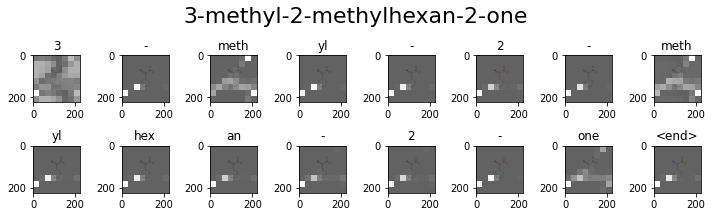

In [52]:
# captions on the validation set
result, attention_plot = evaluate(image_test[123], max_length_test)

print ('Real Caption:', caption_test[123])
print ('Prediction Caption:', ''.join(result[:-1]))

plot_attention(image_test[123], result, attention_plot)

In [53]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [40]:
from nami.AI.kme_tokenize import Segmentation
kme_segment = Segmentation()

In [41]:
best_score = {}
chencherry = SmoothingFunction()

for i in trange(len(image_test)):
  word_arr, _ = evaluate(image_test[i], max_length_test)
  real_word,_ = kme_segment.word_segmentation(caption_test[i])

  score = sentence_bleu([real_word], word_arr[:-1], smoothing_function = chencherry.method4)
  best_score[i] = score
  #print(f"{i} | {score:.4f}", end=' ')
  #print(''.join(word_arr[:-1]), end=' : ')
  #print(caption_test[i])

In [42]:
sort_best_score = sorted(best_score.items(), key=lambda x: x[1], reverse=True)

# BLEU SCORE

In [43]:
for i in range(100):
  print(sort_best_score[i][0], sort_best_score[i][1])

20 0.4546697236991713
9 0.41374412020518814
12 0.35404085389375983
19 0.3013104419866373
83 0.3013040489278569
126 0.2881843430786505
113 0.2840286918096209
135 0.2722589423069702
115 0.270635189136255
117 0.270635189136255
71 0.26866641268043506
93 0.2676032275663791
76 0.2662591197661367
65 0.26337771754817074
44 0.2574866101628968
21 0.2507293112758504
69 0.2477820306346147
90 0.2477820306346147
104 0.2477820306346147
109 0.2477820306346147
127 0.2477820306346147
64 0.2460137257692754
15 0.23793665482062612
33 0.2353015308006209
86 0.2353015308006209
5 0.2287749581206482
23 0.2287749581206482
85 0.22839223781998538
41 0.22481715159810708
50 0.22481715159810708
75 0.22481715159810708
3 0.2238963393399538
6 0.2238963393399538
22 0.2238963393399538
28 0.2238963393399538
30 0.2238963393399538
37 0.2238963393399538
43 0.2238963393399538
52 0.2238963393399538
54 0.2238963393399538
58 0.2238963393399538
66 0.2238963393399538
88 0.2238963393399538
106 0.2238963393399538
32 0.222298495520640

2-ethylhexanol


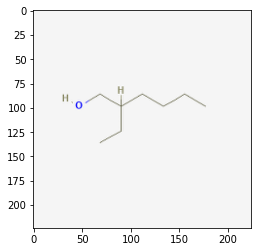

In [44]:
print(caption_test[0])
plt.imshow(image_test[0])

Real Caption: 4-ethyl-2-methylhexane
Prediction Caption: 3-methyl-2-methylhexan-2-one


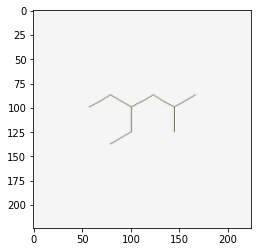

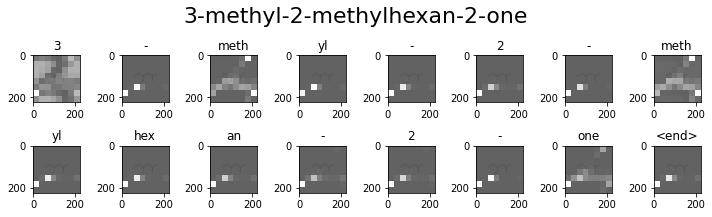

In [55]:
# captions on the validation set
result, attention_plot = evaluate(image_test[9], max_length_test)

print ('Real Caption:', caption_test[9])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[9])
plt.show()
plot_attention(image_test[9], result, attention_plot)


Real Caption: propane-1,2,3-triol
Prediction Caption: 3-methyl-2-methylhexan-2-one


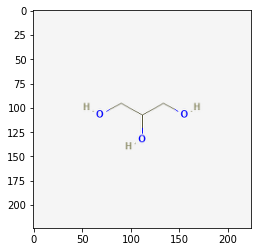

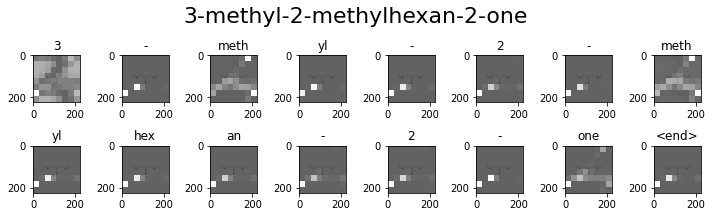

In [46]:
# captions on the validation set
result, attention_plot = evaluate(image_test[25], max_length_test)
2
print ('Real Caption:', caption_test[25])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[25])
plt.show()
plot_attention(image_test[25], result, attention_plot)


Real Caption: N-cyclohexylpropanamide
Prediction Caption: 3-methyl-2-methylhexan-2-one


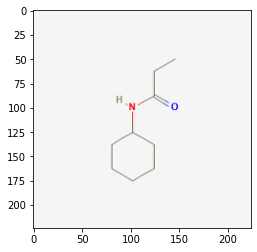

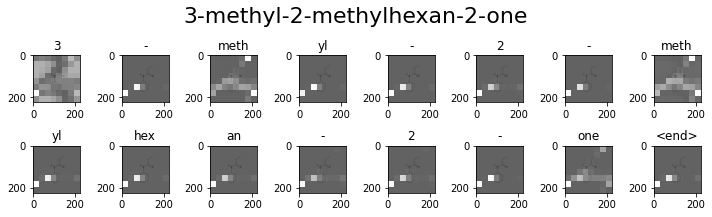

In [47]:
# captions on the validation set
result, attention_plot = evaluate(image_train[98], max_length_train)

print ('Real Caption:', caption_train[98])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_train[98])
plt.show()
plot_attention(image_train[98], result, attention_plot)


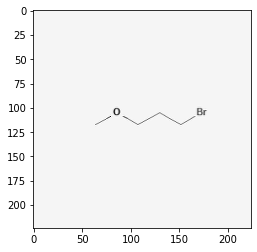

In [48]:
plt.imshow(image_train[0,:,:,0], cmap='gray')

Real Caption: 4-methylcyclohexene
Prediction Caption: 3-methyl-2-methylhexan-2-one


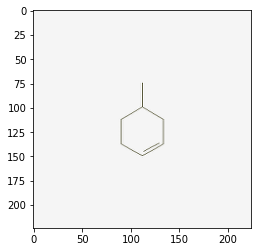

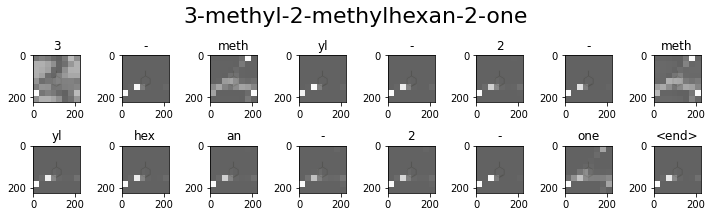

In [49]:
# captions on the validation set
result, attention_plot = evaluate(image_test[100], max_length_test)

print ('Real Caption:', caption_test[100])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[100])
plt.show()
plot_attention(image_test[100], result, attention_plot)
